## Summary
The goal of the project is to 
1. predict the Airbnb listing price in Seattle
2. uncover the important factors that determine the prices of Airbnb listings in Seattle 

The first part of the notebook is EDA of the seattle listings data. Through the exploration of relationship between various variables in the dataset, I decided to do further analysis on the two points of interest above.

The second part is the in-depth analysis to uncover the key factors that influence the listing price. 
* First I built Lasso linear regression model with the original price values as the target, but the performance was unsatisfying. 
* Second try I applied a log transformation on the price because of its long tail shape in distribution, and fit the Lasso model again. This time the R-squared of the test set increased by 7% with the same set of independent variables.
* Finally a Random Forest model is trained with the same set of independent variables and log transformed price as target variable. The top differentiator from RF model is whether the room type is entire apartment while the top coefficients from the linear regression model are mostly about neighborhood. 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('seaborn-notebook')

import warnings
warnings.filterwarnings("ignore")

In [2]:
seattle_listing = pd.read_csv('data/seattle listings.csv')
# seattle_reviews = pd.read_csv('data/seattle reviews.csv')
# seattle_calendar = pd.read_csv('data/seattle calendar.csv')

In [3]:
seattle_listing.head()

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,241032,https://www.airbnb.com/rooms/241032,20160104002432,2016-01-04,Stylish Queen Anne Apartment,NaN,Make your self at home in this charming one-be...,Make your self at home in this charming one-be...,none,NaN,...,10.0,f,NaN,WASHINGTON,f,moderate,f,f,2,4.07
1,953595,https://www.airbnb.com/rooms/953595,20160104002432,2016-01-04,Bright & Airy Queen Anne Apartment,Chemically sensitive? We've removed the irrita...,"Beautiful, hypoallergenic apartment in an extr...",Chemically sensitive? We've removed the irrita...,none,"Queen Anne is a wonderful, truly functional vi...",...,10.0,f,NaN,WASHINGTON,f,strict,t,t,6,1.48
2,3308979,https://www.airbnb.com/rooms/3308979,20160104002432,2016-01-04,New Modern House-Amazing water view,New modern house built in 2013. Spectacular s...,"Our house is modern, light and fresh with a wa...",New modern house built in 2013. Spectacular s...,none,Upper Queen Anne is a charming neighborhood fu...,...,10.0,f,NaN,WASHINGTON,f,strict,f,f,2,1.15
3,7421966,https://www.airbnb.com/rooms/7421966,20160104002432,2016-01-04,Queen Anne Chateau,A charming apartment that sits atop Queen Anne...,NaN,A charming apartment that sits atop Queen Anne...,none,NaN,...,NaN,f,NaN,WASHINGTON,f,flexible,f,f,1,NaN
4,278830,https://www.airbnb.com/rooms/278830,20160104002432,2016-01-04,Charming craftsman 3 bdm house,Cozy family craftman house in beautiful neighb...,Cozy family craftman house in beautiful neighb...,Cozy family craftman house in beautiful neighb...,none,We are in the beautiful neighborhood of Queen ...,...,9.0,f,NaN,WASHINGTON,f,strict,f,f,1,0.89


In [4]:
seattle_listing.columns.shape

(92,)

In [5]:
seattle_listing.dtypes.value_counts()

object     62
float64    17
int64      13
dtype: int64

In [6]:
seattle_listing.columns[seattle_listing.dtypes=='object']

Index(['listing_url', 'last_scraped', 'name', 'summary', 'space',
       'description', 'experiences_offered', 'neighborhood_overview', 'notes',
       'transit', 'thumbnail_url', 'medium_url', 'picture_url',
       'xl_picture_url', 'host_url', 'host_name', 'host_since',
       'host_location', 'host_about', 'host_response_time',
       'host_response_rate', 'host_acceptance_rate', 'host_is_superhost',
       'host_thumbnail_url', 'host_picture_url', 'host_neighbourhood',
       'host_verifications', 'host_has_profile_pic', 'host_identity_verified',
       'street', 'neighbourhood', 'neighbourhood_cleansed',
       'neighbourhood_group_cleansed', 'city', 'state', 'zipcode', 'market',
       'smart_location', 'country_code', 'country', 'is_location_exact',
       'property_type', 'room_type', 'bed_type', 'amenities', 'price',
       'weekly_price', 'monthly_price', 'security_deposit', 'cleaning_fee',
       'extra_people', 'calendar_updated', 'has_availability',
       'calendar_last_s

In [7]:
seattle_listing.columns[seattle_listing.dtypes!='object']

Index(['id', 'scrape_id', 'host_id', 'host_listings_count',
       'host_total_listings_count', 'latitude', 'longitude', 'accommodates',
       'bathrooms', 'bedrooms', 'beds', 'square_feet', 'guests_included',
       'minimum_nights', 'maximum_nights', 'availability_30',
       'availability_60', 'availability_90', 'availability_365',
       'number_of_reviews', 'review_scores_rating', 'review_scores_accuracy',
       'review_scores_cleanliness', 'review_scores_checkin',
       'review_scores_communication', 'review_scores_location',
       'review_scores_value', 'license', 'calculated_host_listings_count',
       'reviews_per_month'],
      dtype='object')

In [8]:
pd.set_option('display.max_colwidth', 0)
seattle_listing[['property_type','room_type','bed_type',  'cancellation_policy',
      'city','market','host_is_superhost','host_identity_verified', 'host_response_time',
      'instant_bookable','neighbourhood','neighbourhood_cleansed',
      'neighbourhood_group_cleansed']].agg(['unique']).transpose()

,unique
property_type,"[Apartment, House, Cabin, Condominium, Camper/RV, Bungalow, Townhouse, Loft, Boat, Bed & Breakfast, Other, Dorm, Treehouse, Yurt, Chalet, Tent, nan]"
room_type,"[Entire home/apt, Private room, Shared room]"
bed_type,"[Real Bed, Futon, Pull-out Sofa, Airbed, Couch]"
cancellation_policy,"[moderate, strict, flexible]"
city,"[Seattle, Ballard, Seattle, West Seattle, Seattle , 西雅图, Phinney Ridge Seattle, seattle]"
market,[Seattle]
host_is_superhost,"[f, t, nan]"
host_identity_verified,"[t, f, nan]"
host_response_time,"[within a few hours, within an hour, nan, within a day, a few days or more]"
instant_bookable,"[f, t]"


In [9]:
seattle_listing[['neighbourhood','neighbourhood_cleansed','neighbourhood_group_cleansed']].isnull().sum()

neighbourhood                   416
neighbourhood_cleansed          0  
neighbourhood_group_cleansed    0  
dtype: int64

In [10]:
seattle_listing[['review_scores_rating',
       'review_scores_accuracy', 'review_scores_cleanliness',
       'review_scores_checkin', 'review_scores_communication',
       'review_scores_location', 'review_scores_value']].head()

,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value
0,95.0,10.0,10.0,10.0,10.0,9.0,10.0
1,96.0,10.0,10.0,10.0,10.0,10.0,10.0
2,97.0,10.0,10.0,10.0,10.0,10.0,10.0
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,92.0,9.0,9.0,10.0,10.0,9.0,9.0


In [11]:
seattle_listing[['host_response_rate', 'host_acceptance_rate', 'weekly_price','monthly_price', 'security_deposit', 'cleaning_fee', 'extra_people']].head()

,host_response_rate,host_acceptance_rate,weekly_price,monthly_price,security_deposit,cleaning_fee,extra_people
0,96%,100%,NaN,NaN,NaN,NaN,$5.00
1,98%,100%,"$1,000.00","$3,000.00",$100.00,$40.00,$0.00
2,67%,100%,NaN,NaN,"$1,000.00",$300.00,$25.00
3,NaN,NaN,$650.00,"$2,300.00",NaN,NaN,$0.00
4,100%,NaN,NaN,NaN,$700.00,$125.00,$15.00


In [12]:
seattle_listing[['host_response_time',
       'host_response_rate', 'host_acceptance_rate', 'host_is_superhost',
        'neighbourhood', 'neighbourhood_cleansed',
       'neighbourhood_group_cleansed',
        'property_type', 'room_type', 'accommodates',
       'bathrooms', 'bedrooms', 'beds', 'bed_type', 'amenities', 'square_feet',
       'price', 'weekly_price', 'monthly_price']].head()

,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,square_feet,price,weekly_price,monthly_price
0,within a few hours,96%,100%,f,Queen Anne,West Queen Anne,Queen Anne,Apartment,Entire home/apt,4,1.0,1.0,1.0,Real Bed,"{TV,""Cable TV"",Internet,""Wireless Internet"",""Air Conditioning"",Kitchen,Heating,""Family/Kid Friendly"",Washer,Dryer}",NaN,$85.00,NaN,NaN
1,within an hour,98%,100%,t,Queen Anne,West Queen Anne,Queen Anne,Apartment,Entire home/apt,4,1.0,1.0,1.0,Real Bed,"{TV,Internet,""Wireless Internet"",Kitchen,""Free Parking on Premises"",""Buzzer/Wireless Intercom"",Heating,""Family/Kid Friendly"",Washer,Dryer,""Smoke Detector"",""Carbon Monoxide Detector"",""First Aid Kit"",""Safety Card"",""Fire Extinguisher"",Essentials}",NaN,$150.00,"$1,000.00","$3,000.00"
2,within a few hours,67%,100%,f,Queen Anne,West Queen Anne,Queen Anne,House,Entire home/apt,11,4.5,5.0,7.0,Real Bed,"{TV,""Cable TV"",Internet,""Wireless Internet"",""Air Conditioning"",Kitchen,""Free Parking on Premises"",""Pets Allowed"",""Pets live on this property"",Dog(s),Cat(s),""Hot Tub"",""Indoor Fireplace"",Heating,""Family/Kid Friendly"",Washer,Dryer,""Smoke Detector"",""Carbon Monoxide Detector"",Essentials,Shampoo}",NaN,$975.00,NaN,NaN
3,NaN,NaN,NaN,f,Queen Anne,West Queen Anne,Queen Anne,Apartment,Entire home/apt,3,1.0,0.0,2.0,Real Bed,"{Internet,""Wireless Internet"",Kitchen,""Indoor Fireplace"",Heating,""Family/Kid Friendly"",Washer,Dryer,""Smoke Detector"",""Carbon Monoxide Detector"",""Safety Card"",""Fire Extinguisher"",Essentials,Shampoo}",NaN,$100.00,$650.00,"$2,300.00"
4,within an hour,100%,NaN,f,Queen Anne,West Queen Anne,Queen Anne,House,Entire home/apt,6,2.0,3.0,3.0,Real Bed,"{TV,""Cable TV"",Internet,""Wireless Internet"",Kitchen,Heating,""Family/Kid Friendly"",""Smoke Detector"",""Carbon Monoxide Detector"",""First Aid Kit"",""Fire Extinguisher"",Essentials,Shampoo}",NaN,$450.00,NaN,NaN


In [13]:
seattle_listing[[ 'security_deposit',
       'cleaning_fee', 'guests_included', 'extra_people', 'minimum_nights',
       'maximum_nights', 'calendar_updated', 'has_availability',
       'availability_30', 'availability_60', 'availability_90',
       'availability_365']].head()

,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365
0,NaN,NaN,2,$5.00,1,365,4 weeks ago,t,14,41,71,346
1,$100.00,$40.00,1,$0.00,2,90,today,t,13,13,16,291
2,"$1,000.00",$300.00,10,$25.00,4,30,5 weeks ago,t,1,6,17,220
3,NaN,NaN,1,$0.00,1,1125,6 months ago,t,0,0,0,143
4,$700.00,$125.00,6,$15.00,1,1125,7 weeks ago,t,30,60,90,365


In [14]:
seattle_listing.id.unique().shape[0]

3818

## Exploratory Analysis

#### 1.1 Do superhosts always have higher ratings than regular airbnb hosts?

In [15]:
# how many hosts are actually superhosts?
seattle_listing.host_is_superhost.value_counts()

f    3038
t    778 
Name: host_is_superhost, dtype: int64

In [16]:
avg_rating = seattle_listing.groupby('host_is_superhost')['review_scores_rating'].mean()
print('Average rating score for regular hosts is {}'.format(avg_rating[0]))
print('Average rating score for super hosts is {}'.format(avg_rating[1]))

Average rating score for regular hosts is 93.65289256198348
Average rating score for super hosts is 97.39547270306258


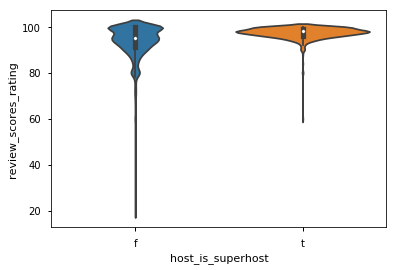

In [17]:
sns.violinplot(seattle_listing['host_is_superhost'], seattle_listing['review_scores_rating'])

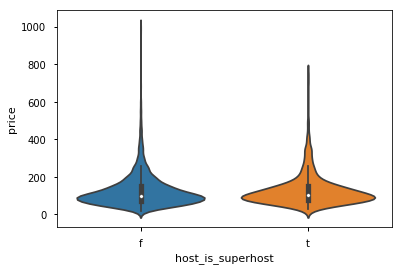

In [18]:
seattle_listing['price'] = seattle_listing['price'].str.replace('$','').str.replace('%','').str.replace(',','').astype('float64')
sns.violinplot(seattle_listing['host_is_superhost'], seattle_listing['price'])

* The review score rating shows an evident distinction between the super hosts and regular hosts - the majority of super host ratings clutter around 90–100, compared to only 61% ratings above 90 for the regular hosts, due to the long tail in the lower ratings. The price distribution, on the other hand, seems to be the same for both types of hosts except a few rare extremely high price outliers from the regular hosts.

#### 1.2 What are the average listing prices of different property types by neighborhood?

In [19]:
seattle_listing['property_type'].value_counts()

House              1733
Apartment          1708
Townhouse          118 
Condominium        91  
Loft               40  
Bed & Breakfast    37  
Other              22  
Cabin              21  
Camper/RV          13  
Bungalow           13  
Boat               8   
Tent               5   
Treehouse          3   
Dorm               2   
Chalet             2   
Yurt               1   
Name: property_type, dtype: int64

In [20]:
seattle_listing['property_type_cleaned'] = seattle_listing['property_type'].apply(lambda x: 'Townhouse & Condom' if x in ['Townhouse','Condominium']\
                                                                                 else 'Other' if x not in ['Townhouse','Condominium','House','Apartment'] else x) 

In [21]:
seattle_listing['property_type_cleaned'].value_counts()

House                 1733
Apartment             1708
Townhouse & Condom    209 
Other                 168 
Name: property_type_cleaned, dtype: int64

(array([0, 1, 2, 3]), <a list of 4 Text xticklabel objects>)

<Figure size 1440x720 with 0 Axes>

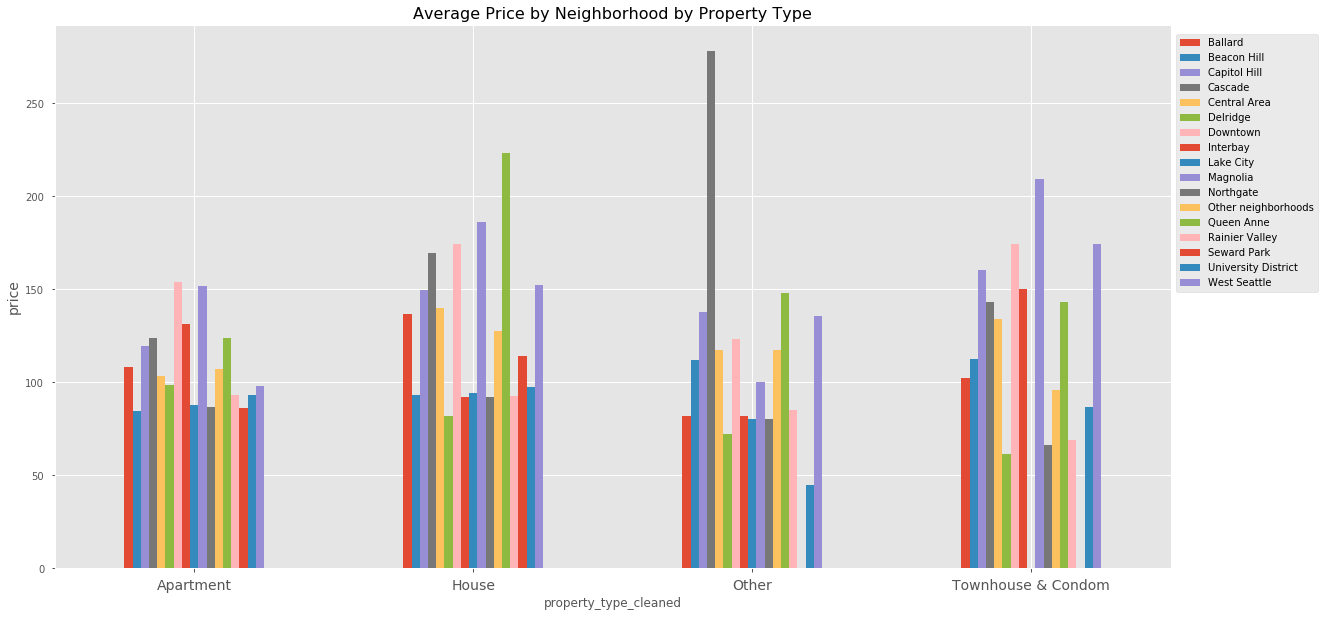

In [22]:
plt.style.use('ggplot')
plt.figure(figsize=(20,10))
seattle_listing.groupby(['property_type_cleaned','neighbourhood_group_cleansed'])['price'].mean().unstack().plot.bar(figsize=(20,10), rot=0)
plt.ylabel('price', fontsize = 14)
plt.title('Average Price by Neighborhood by Property Type', fontsize = 16)
plt.legend(bbox_to_anchor=(1.00, 0.5), loc=3);
plt.xticks(fontsize = 14)

#### 1.3 Is there multicollinearity among the review feature group?

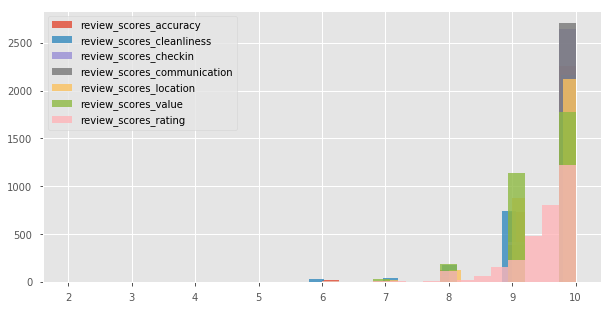

In [23]:
review_col = [ 'review_scores_accuracy', 'review_scores_cleanliness',
       'review_scores_checkin', 'review_scores_communication',
       'review_scores_location', 'review_scores_value','review_scores_rating']
review_df = seattle_listing[review_col].copy()
review_df['review_scores_rating'] = review_df['review_scores_rating']/10
fig, ax = plt.subplots(figsize=(10, 5))
for col in review_col:    
    review_df[col].hist(bins=30, alpha=0.8)
    #plt.title(col)
plt.legend(review_col, loc='upper left', fontsize = 10)    

In [24]:
from scipy import stats
import statsmodels.api as sm
review_df2 = review_df.dropna()
y = review_df2['review_scores_rating']
x = review_df2[['review_scores_accuracy', 'review_scores_cleanliness',
       'review_scores_checkin', 'review_scores_communication',
       'review_scores_location', 'review_scores_value']]
est = sm.OLS(y, x).fit()
print(est.summary())

                             OLS Regression Results                             
Dep. Variable:     review_scores_rating   R-squared:                       0.998
Model:                              OLS   Adj. R-squared:                  0.998
Method:                   Least Squares   F-statistic:                 3.164e+05
Date:                  Wed, 21 Aug 2019   Prob (F-statistic):               0.00
Time:                          13:04:58   Log-Likelihood:                -1473.7
No. Observations:                  3158   AIC:                             2959.
Df Residuals:                      3152   BIC:                             2996.
Df Model:                             6                                         
Covariance Type:              nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------

After exploring the dataset a little bit, I start to have some clear idea about the type of business questions I want to address with the data availabel through more in-depth analysis and modeling.

### Questions to address: 
##### 1. What are the key factors that contribute to the price of a listing? 
##### 2. If given all the information of a airbnb listing, can we predict its nightly price with reasonable confidence?

## Data Cleaning & Feature Selection

In [25]:
# remove some unrelated and correlated columns to the analyses of interest to keep only the necessary columns
keep_col = [ 
        'host_response_time',
       'host_response_rate', 'host_acceptance_rate', 'host_is_superhost',
       'neighbourhood_cleansed','neighbourhood_group_cleansed', 
        'property_type_cleaned', 'room_type', 'accommodates',
       'bathrooms', 'bedrooms', 'beds', 'bed_type','square_feet',
       'price', 'security_deposit',
       'cleaning_fee', 'guests_included', 'extra_people',
       'availability_90',
       'number_of_reviews',
       'review_scores_rating',
       'review_scores_accuracy', 'review_scores_cleanliness',
       'review_scores_checkin', 'review_scores_communication',
       'review_scores_location', 'review_scores_value', 'instant_bookable',
       'cancellation_policy', 
       'reviews_per_month']

In [26]:
listing_clean = seattle_listing[keep_col]
listing_clean.head()

,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,neighbourhood_cleansed,neighbourhood_group_cleansed,property_type_cleaned,room_type,accommodates,bathrooms,...,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,cancellation_policy,reviews_per_month
0,within a few hours,96%,100%,f,West Queen Anne,Queen Anne,Apartment,Entire home/apt,4,1.0,...,95.0,10.0,10.0,10.0,10.0,9.0,10.0,f,moderate,4.07
1,within an hour,98%,100%,t,West Queen Anne,Queen Anne,Apartment,Entire home/apt,4,1.0,...,96.0,10.0,10.0,10.0,10.0,10.0,10.0,f,strict,1.48
2,within a few hours,67%,100%,f,West Queen Anne,Queen Anne,House,Entire home/apt,11,4.5,...,97.0,10.0,10.0,10.0,10.0,10.0,10.0,f,strict,1.15
3,NaN,NaN,NaN,f,West Queen Anne,Queen Anne,Apartment,Entire home/apt,3,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,f,flexible,NaN
4,within an hour,100%,NaN,f,West Queen Anne,Queen Anne,House,Entire home/apt,6,2.0,...,92.0,9.0,9.0,10.0,10.0,9.0,9.0,f,strict,0.89


#### Numerical Features

In [27]:
#convert numerical columns to float from string
for col in ['host_response_rate', 'host_acceptance_rate','security_deposit','cleaning_fee','extra_people']:
    listing_clean[col] = listing_clean[col].str.replace('$','').str.replace('%','').str.replace(',','').astype('float64')

In [28]:
listing_clean[['host_response_rate', 'host_acceptance_rate','security_deposit','cleaning_fee','extra_people']].head()

,host_response_rate,host_acceptance_rate,security_deposit,cleaning_fee,extra_people
0,96.0,100.0,NaN,NaN,5.0
1,98.0,100.0,100.0,40.0,0.0
2,67.0,100.0,1000.0,300.0,25.0
3,NaN,NaN,NaN,NaN,0.0
4,100.0,NaN,700.0,125.0,15.0


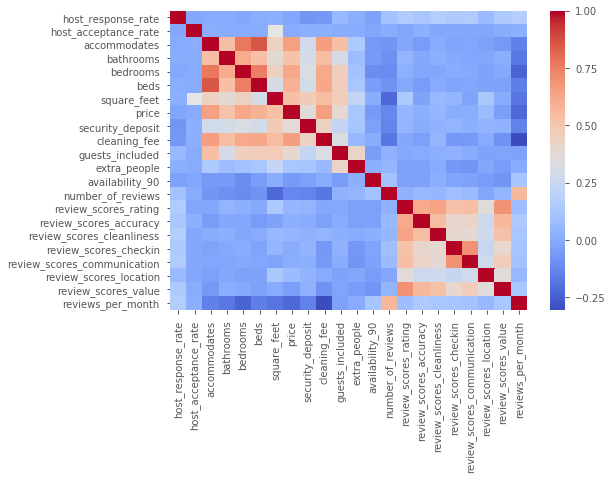

In [29]:
plt.style.use('seaborn-notebook')
feature_corr = listing_clean.corr()
sns.heatmap(feature_corr, cmap = 'coolwarm')

price seems to be most correlated with `accomodate`, `bedrooms`, `beds` and `cleaning fee`.

####  categorical features

In [30]:
categorical_col = list(listing_clean.dtypes[listing_clean.dtypes=='object'].index)

In [31]:
categorical_col

['host_response_time',
 'host_is_superhost',
 'neighbourhood_cleansed',
 'neighbourhood_group_cleansed',
 'property_type_cleaned',
 'room_type',
 'bed_type',
 'instant_bookable',
 'cancellation_policy']

In [32]:
import statsmodels.api as sm
from statsmodels.formula.api import ols
Anova_test_F_value=[]
Anova_test_p_value=[]
variable_name_list=[]
for variable in categorical_col: 
    mod = ols('price ~ '+ variable, data = listing_clean).fit()
    aov_table = sm.stats.anova_lm(mod, typ=2)
    Fvalue=aov_table.loc[variable, 'F']
    Pvalue=aov_table.loc[variable, 'PR(>F)']
    variable_name_list.append(variable)
    Anova_test_F_value.append(Fvalue)
    Anova_test_p_value.append(Pvalue)

Anova_categorical_variable_test=pd.DataFrame({"Variable": variable_name_list, "F Value":Anova_test_F_value, \
                                              "P Value":Anova_test_p_value })

In [33]:
Anova_categorical_variable_test.sort_values(by='F Value', ascending=False)

,Variable,F Value,P Value
5,room_type,454.294433,1.063720e-177
8,cancellation_policy,104.399976,7.193535e-45
6,bed_type,15.527490,1.320561e-12
3,neighbourhood_group_cleansed,14.150561,5.984737e-38
0,host_response_time,10.394338,8.333510e-07
4,property_type_cleaned,4.545589,3.480173e-03
2,neighbourhood_cleansed,4.469254,7.199322e-37
7,instant_bookable,3.841430,5.007353e-02
1,host_is_superhost,0.574475,4.485329e-01


Two-way ANOVA test is the easiest way to see the effect of each categorical factors on the target variable "price". If the P value is high and F statistics is close to 1, that means the within group(categorical level) variance of the price is the same as between group variance, so we can say the categorical feature does not have much predicting power because there is no variance in price between categorical levels. 

Conversely, The higher the F test statistics, the more the differences are of average prices between different levels of the categorical variable, and the more power the categorical variable have in predicting the price.

Aparently from the Anova test result, we can first eliminate the bottom two features because their Pvalues are too high to be considered statistically significant. Given the small F statistics, we can conclude there is ver small varibility of price between the two levels of `host_is_superhost` and `instant_bookable`. 

Also, there are two features related to `neighbourhood`. From the exploratory analysis above, it is obvious that neighborhoods affect the listing price. But since they basically contain very similar information except that `neighborhood_cleansed` is in a more granular level, I wnat to keep only one of them. The F statistics gives a very clear idea about which one to choose. I will keep `neighbourhood_group_cleansed` because it has a higher F score.

#### Missing values

In [34]:
delete_col = ['host_is_superhost','instant_bookable', 'neighbourhood_cleansed', 'review_scores_accuracy', 'review_scores_cleanliness',\
             'review_scores_checkin', 'review_scores_communication', 'review_scores_location']
listing_clean2 = listing_clean.drop(delete_col, axis=1)
# for col in tf_col:
#     listing_clean[col] = np.where(listing_clean[col]=='t',1,0)
categorical_keep_col = [i for i in categorical_col if i not in delete_col ]    
na_col = listing_clean2.isnull().sum()[listing_clean2.isnull().sum()>0].index
listing_clean2[na_col].isnull().sum()


host_response_time      523 
host_response_rate      523 
host_acceptance_rate    773 
bathrooms               16  
bedrooms                6   
beds                    1   
square_feet             3721
security_deposit        1952
cleaning_fee            1030
review_scores_rating    647 
review_scores_value     656 
reviews_per_month       627 
dtype: int64

`square_feet` has over 97% NaN values, so I will drop it. For cleaning_fee and security_deposit I will impute the Nan with 0.  For the rest of the numerical features, I will impute the NaN with the median in the machine learning pipeline later to avoid data leakage in the test set.

`host_response_time` is the only categorical feature that contains Nan, I will impute it the mode before one-hot encoding them.

In [35]:
del listing_clean2['square_feet'] # delete square_feet due to large % of missing values

In [36]:
# continuous variables 
impute_0_col = ['security_deposit','cleaning_fee']
impute_median_col = [ 'host_response_rate','host_acceptance_rate','bathrooms', 'bedrooms', 'beds',
                    'review_scores_rating','review_scores_accuracy', 'review_scores_cleanliness','review_scores_checkin', 'review_scores_communication',
                    'review_scores_location', 'review_scores_value', 'reviews_per_month']
# categorical variables, fill with the mode value
impute_mode_col = ['host_response_time']

listing_clean2[impute_0_col].fillna(0)
# impute the missing categorical values before one-hot encoding
for col in impute_mode_col:
    listing_clean2[col].fillna(listing_clean2[col].mode()[0], inplace=True)

In [37]:
listing_clean2.shape

(3818, 22)

In [38]:
listing_clean_dummy = pd.get_dummies(listing_clean2, columns= categorical_keep_col)

In [39]:
listing_clean_dummy.dtypes.value_counts()

uint8      36
float64    12
int64      4 
dtype: int64

In [40]:
dummy_col = list(listing_clean_dummy.dtypes[listing_clean_dummy.dtypes=='uint8'].index) 
numerical_col = [i for i in listing_clean_dummy.columns if i not in dummy_col and i not in delete_col ]

## Price Prediction

In [41]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(listing_clean_dummy.drop('price',axis=1), listing_clean_dummy['price'], test_size=0.2)

In [42]:
dummy_col = list(listing_clean_dummy.dtypes[listing_clean_dummy.dtypes=='uint8'].index) 
numerical_col = [i for i in listing_clean_dummy.columns if i not in dummy_col and i not in delete_col ]
numerical_col_index = [list(x_train.columns).index(i) for i in numerical_col if i != 'price']
dummy_col_index = [list(x_train.columns).index(i) for i in dummy_col]

### 1. Linear regression

In [43]:
from regressors import stats
from sklearn import linear_model
from sklearn.impute import SimpleImputer

imp = SimpleImputer(strategy = 'median')
x_train_clean = imp.fit_transform(x_train)
ols = linear_model.LinearRegression()
ols.fit(x_train_clean, y_train)
stats.summary(ols, x_train_clean, y_train, xlabels = x_train.columns)

Residuals:
      Min      1Q  Median       3Q       Max
-854.6557 -18.179  3.8506  26.6275  213.5699


Coefficients:
                                                   Estimate                          Std. Error            t value   p value
_intercept                                       -24.947531  (10919636.225692+19435519.884415j)  (-0+0j)            0.999999
host_response_rate                                0.186766   (0.520258+0.946008j)                (0.0834-0.1516j)   0.862670
host_acceptance_rate                             -0.466640   (1.524691+0.115007j)                (-0.3043+0.023j)   0.760243
accommodates                                      7.149744   (1.129248+0.409091j)                (5.5969-2.0276j)   0.000000
bathrooms                                         21.126979  (1.76612+0.994763j)                 (9.0813-5.115j)    0.000000
bedrooms                                          28.959917  (2.540774+0.375227j)                (11.1548-1.6474j)  0.000000
beds    

### 1. A simiple linear regression with regularization (Lasso)

In [46]:
from sklearn.preprocessing import StandardScaler,FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline,FeatureUnion
from sklearn.linear_model import LassoCV, ElasticNetCV, RidgeCV

pipeline=Pipeline(steps = [
    ('imputer',SimpleImputer(strategy = 'median')),
    ('feature_processing', FeatureUnion(transformer_list = [
            ('categorical', FunctionTransformer(lambda data: data[:,dummy_col_index])),

            #only impute and standardize numeric data
            ('numeric', Pipeline(steps = [
                ('select', FunctionTransformer(lambda data: data[:,numerical_col_index])),
                ('scaler', StandardScaler())
                        ]))
        ])),
    ('model', RidgeCV(cv=10))
    ]
)

In [47]:
pipeline.fit(x_train, y_train)

Pipeline(memory=None,
     steps=[('imputer', SimpleImputer(copy=True, fill_value=None, missing_values=nan,
       strategy='median', verbose=0)), ('feature_processing', FeatureUnion(n_jobs=None,
       transformer_list=[('categorical', FunctionTransformer(accept_sparse=False, check_inverse=True,
          func=<function <lam...v=10, fit_intercept=True,
    gcv_mode=None, normalize=False, scoring=None, store_cv_values=False))])

In [48]:
print('training r2 score: {}'.format(pipeline.score(x_train, y_train)))
y_pred_lasso = pipeline.predict(x_test)
print('test r2 score: {}'.format(pipeline.score(x_test, y_test)))

training r2 score: 0.6052317263587113
test r2 score: 0.5769024142883346


In [49]:
# test how close the predicted prices are against true price
rand_id_1 = np.random.choice(y_test.index, 1)[0]
print('real price of listing id {} is {}, the predicted price is {}'.format(seattle_listing.loc[rand_id_1].id, y_test.loc[rand_id_1], round(y_pred_lasso[np.argwhere(y_test.index== rand_id_1)[0][0]],2) ))

rand_id_2 = np.random.choice(y_test.index, 1)[0]
print('real price of listing id {} is {}, the predicted price is {}'.format(seattle_listing.loc[rand_id_2].id, y_test.loc[rand_id_2], round(y_pred_lasso[np.argwhere(y_test.index== rand_id_2)[0][0]],2) ))

real price of listing id 1090449 is 135.0, the predicted price is 139.46
real price of listing id 1538865 is 90.0, the predicted price is 140.59


In [50]:
zero_coef = pd.Series(pipeline.named_steps['model'].coef_, index= x_train.columns)
zero_coef[zero_coef==0]

Series([], dtype: float64)

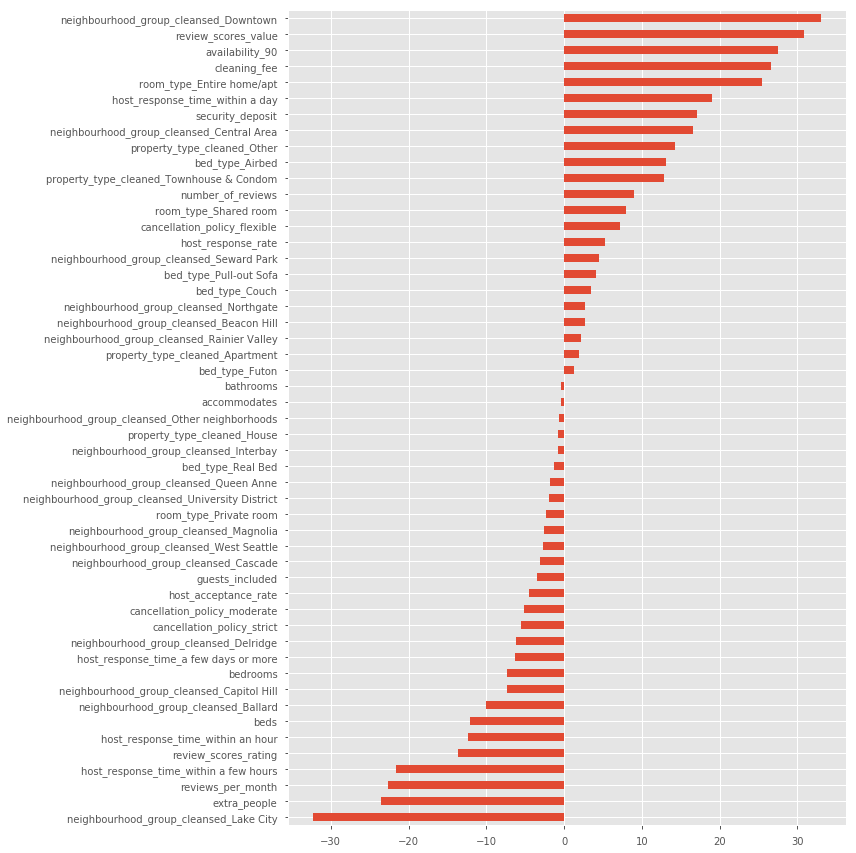

In [51]:
plt.figure(figsize=(10,15))
#plt.subplot(2,1,2)
pd.Series(pipeline.named_steps['model'].coef_, index= x_train.columns).sort_values().plot.barh()

# plt.subplot(2,1,1)
# pd.Series(pipeline.named_steps['model'].coef_, index= x_train.columns).sort_values()[-20:].plot.barh()


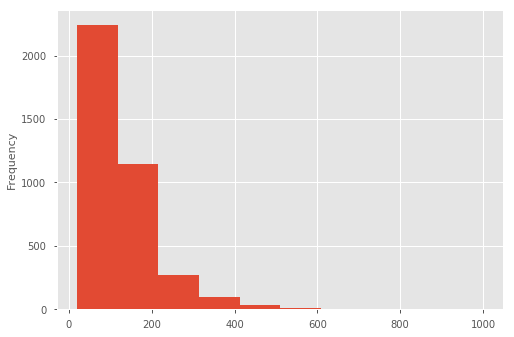

In [54]:
listing_clean.price.plot.hist()

##### Interpretation
Since all the numerical features in the training data have been standardized, the 1 unit change in any of the numerical features is no longer in their original scale but by the standard deviation. We did not standardize the categorical variables, so their unit of change is unchanged.

So we can say if the number of people the listing accommodates increases by 1 standard deviation(~ 2 people), the price of the listing will increase by 23  on average, holding everything else constant. Or if the review scores rating increases by 1 std(6.6 in the scale of 100), the price will go up by 27.5 on average. For categorical variables, the average price of a listing in the downtown area is $33 more expensive than that of a similar listing elsewhere.

##### Thoughts
* Given the long tail shape of the price distribution, what will happen if I apply a log transformation on price and use the log price as target variable?

(array([  23.,  164.,  426., 1040., 1041.,  678.,  288.,  116.,   29.,
          13.]),
 array([2.99573227, 3.38693457, 3.77813687, 4.16933918, 4.56054148,
        4.95174378, 5.34294608, 5.73414838, 6.12535068, 6.51655298,
        6.90775528]),
 <a list of 10 Patch objects>)

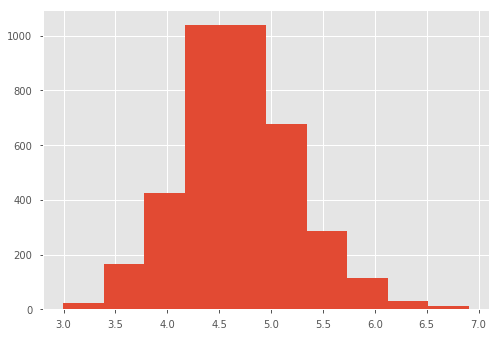

In [55]:
plt.hist(np.log(listing_clean_dummy.price))

### 2. Lasso regression with regularization using log(price) as dependent variable

In [56]:
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler,FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline,FeatureUnion
from sklearn.linear_model import LassoCV, ElasticNetCV, RidgeCV

pipeline2=Pipeline(steps = [
    ('imputer',SimpleImputer(strategy = 'median')),
    ('feature_processing', FeatureUnion(transformer_list = [
            ('categorical', FunctionTransformer(lambda data: data[:,dummy_col_index])),

            #only impute and standardize numeric data
            ('numeric', Pipeline(steps = [
                ('select', FunctionTransformer(lambda data: data[:,numerical_col_index])),
                ('scaler', StandardScaler())
                        ]))
        ])),
    ('model', LassoCV(n_alphas=200, cv=10))
    ]
)
pipeline2.fit(x_train, np.log(y_train))

Pipeline(memory=None,
     steps=[('imputer', SimpleImputer(copy=True, fill_value=None, missing_values=nan,
       strategy='median', verbose=0)), ('feature_processing', FeatureUnion(n_jobs=None,
       transformer_list=[('categorical', FunctionTransformer(accept_sparse=False, check_inverse=True,
          func=<function <lam...ve=False, precompute='auto', random_state=None,
    selection='cyclic', tol=0.0001, verbose=False))])

In [57]:
print('training r2 score: {}'.format(pipeline2.score(x_train, np.log(y_train))))
y_pred_lasso2 = pipeline2.predict(x_test)
print('test r2 score: {}'.format(pipeline2.score(x_test, np.log(y_test))))

training r2 score: 0.6870029342499613
test r2 score: 0.6784737951182958


##### check P values for the features

In [45]:
from regressors import stats
from sklearn import linear_model
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

imp = SimpleImputer(strategy = 'median')
std = StandardScaler()
x_train_clean = imp.fit_transform(x_train)
x_train_std = std.fit_transform(x_train_clean)
ols = linear_model.LassoCV(cv=10)
ols.fit(x_train_std, np.log(y_train))
print(stats.summary(ols, x_train_std, np.log(y_train), xlabels = x_train.columns))

Residuals:
    Min      1Q  Median      3Q     Max
-1.9968 -0.1855  0.0011  0.2083  1.4707


Coefficients:
                                                  Estimate                   Std. Error       t value   p value
_intercept                                        4.677791  (0.005736+0j)                (815.538+0j)  0.000000
host_response_rate                                0.014628  (0.007517+0j)                (1.9459-0j)   0.051758
host_acceptance_rate                             -0.010993  (0.005829-0j)                (-1.8861-0j)  0.059373
accommodates                                      0.102136  (0.012991-0j)                (7.8622+0j)   0.000000
bathrooms                                         0.033121  (0.0074-0j)                  (4.4759+0j)   0.000008
bedrooms                                          0.146620  (0.010415+0j)                (14.078-0j)   0.000000
beds                                             -0.022579  (0.011049+0j)                (-2.0435+0j)  0.0410

In [58]:
# test how close the predicted prices are against true price
# to conver the predicted price back to normal , just apply np.exp on the prediced price.
rand_id_1 = np.random.choice(y_test.index, 1)[0]
print('real price of listing id {} is {}, the predicted price is {}'.format(seattle_listing.loc[rand_id_1].id, y_test.loc[rand_id_1], np.exp(y_pred_lasso2[np.argwhere(y_test.index== rand_id_1)[0][0]]) ))

rand_id_2 = np.random.choice(y_test.index, 1)[0]
print('real price of listing id {} is {}, the predicted price is {}'.format(seattle_listing.loc[rand_id_2].id, y_test.loc[rand_id_2], np.exp(y_pred_lasso2[np.argwhere(y_test.index== rand_id_2)[0][0]]) ))

real price of listing id 9368677 is 125.0, the predicted price is 172.52441688123955
real price of listing id 7420762 is 90.0, the predicted price is 102.74566519236375


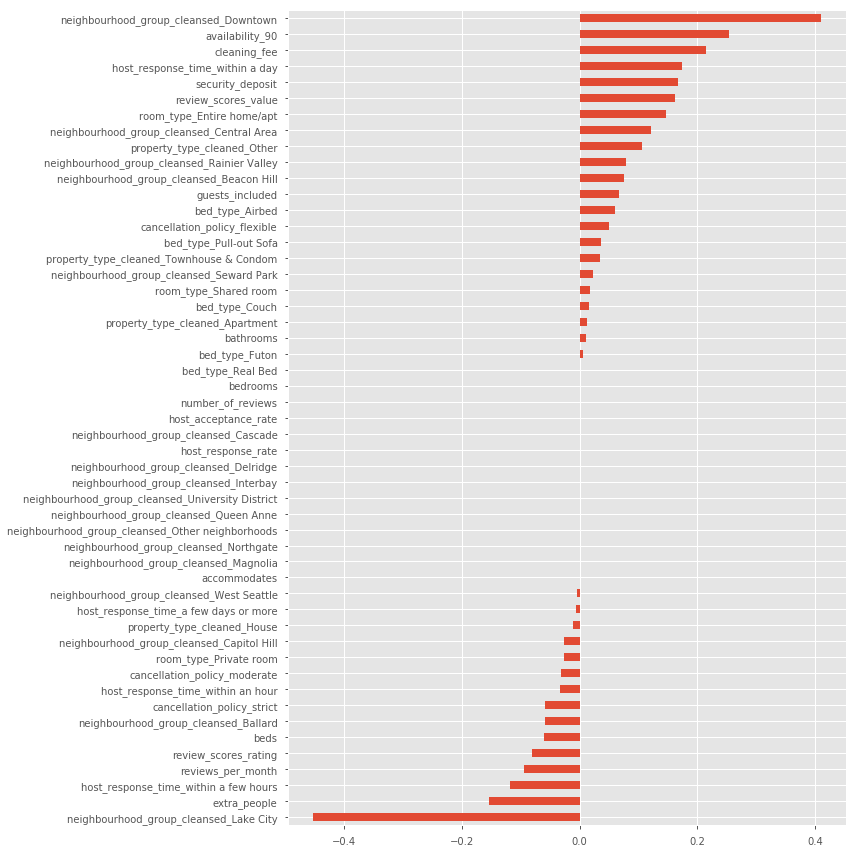

In [59]:
plt.figure(figsize=(10,15))
#plt.subplot(2,1,2)
pd.Series(pipeline2.named_steps['model'].coef_, index= x_train.columns).sort_values().plot.barh()#[:30].plot.barh()

# plt.subplot(2,1,1)
# pd.Series(pipeline2.named_steps['model'].coef_, index= x_train.columns).sort_values()[-30:].plot.barh()


#####  Interpretaion:

The downtown area is most positively correlated to the price- listing in downtown can be 50% (exp(0.45)-1 = 0.5) more expensive than non-downtown area holding everything else constant. On the contrary, the Lake City area is most negatively correlated to the price. If a listing is in Lake City area, the price will be 36% ((exp(-0.45)-1)*100%) lower than non-Lake City area.

The more security deposit the lower the prices.

### 3. Random Forest using log(price) as dependent variable

In [60]:
price_95pctile = np.percentile(listing_clean_dummy.price.values, 95)
listing_clean_nooutlier = listing_clean_dummy.loc[listing_clean_dummy.price < price_95pctile, :]
x_train, x_test, y_train, y_test = train_test_split(listing_clean_nooutlier.drop('price',axis=1), listing_clean_nooutlier['price'], test_size=0.2)

In [67]:
# random forest
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

pipeline4=Pipeline(steps = [
    ('imputer',SimpleImputer(strategy = 'median')),
    ('model', RandomForestRegressor(n_estimators=500, oob_score= True))
    ]
)

params = {'model__max_depth': [10, 12], 'model__min_samples_leaf': [0.0005, 0.001, 0.0025]}
cv = GridSearchCV(pipeline4, params, cv=10)

cv.fit(x_train, np.log(y_train))

GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('imputer', SimpleImputer(copy=True, fill_value=None, missing_values=nan,
       strategy='median', verbose=0)), ('model', RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impu...ators=500, n_jobs=None,
           oob_score=True, random_state=None, verbose=0, warm_start=False))]),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'model__max_depth': [10, 12], 'model__min_samples_leaf': [0.0005, 0.001, 0.0025]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [68]:
print('r2 for training set using random forest is {}'.format(cv.score(x_train, np.log(y_train))))
best_model = cv.best_estimator_
y_pred_rf = best_model.predict(x_test)
print('best parameters: {}'.format(cv.best_params_))
print('r2 for test set using random forest is {}'.format(cv.score(x_test, np.log(y_test))))

r2 for training set using random forest is 0.869888343600839
best parameters: {'model__max_depth': 12, 'model__min_samples_leaf': 0.0005}
r2 for test set using random forest is 0.6455428452980536


In [65]:
# test how close the predicted prices are against true price
rand_id_1 = np.random.choice(y_test.index, 1)[0]
print('real price of listing id {} is {}, the predicted price is {}'.format(seattle_listing.loc[rand_id_1].id, y_test.loc[rand_id_1], np.exp(y_pred_rf[np.argwhere(y_test.index== rand_id_1)[0][0]] )))

rand_id_2 = np.random.choice(y_test.index, 1)[0]
print('real price of listing id {} is {}, the predicted price is {}'.format(seattle_listing.loc[rand_id_2].id, y_test.loc[rand_id_2], np.exp(y_pred_rf[np.argwhere(y_test.index== rand_id_2)[0][0]] )))

real price of listing id 1356339 is 119.0, the predicted price is 119.62367126656552
real price of listing id 8995844 is 250.0, the predicted price is 179.9249976795107


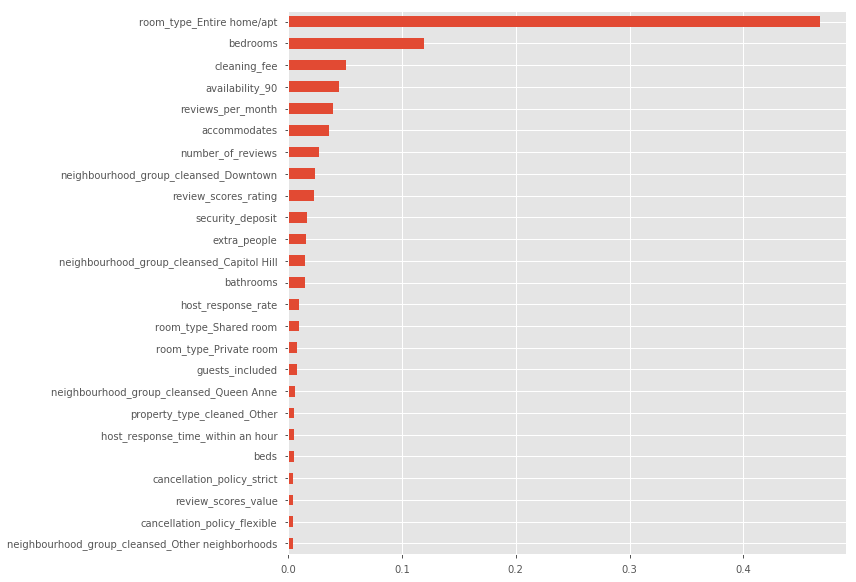

In [66]:
# feature importance
plt.figure(figsize=(10,10))
#plt.subplot(2,1,2)
pd.Series(cv.best_estimator_.named_steps['model'].feature_importances_, index= x_train.columns).sort_values()[-25:].plot.barh()


##### Interpretation
Quite different from the coefficients result from Lasso regression, Random Forest model ranks the property type as the top feature that affects the price the most, followed by number of bedrooms.

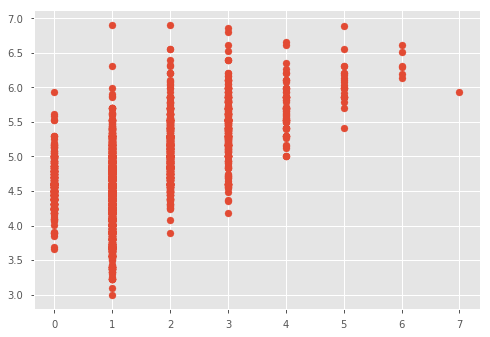

In [69]:
plt.scatter(listing_clean_dummy.bedrooms, np.log(listing_clean_dummy.price))

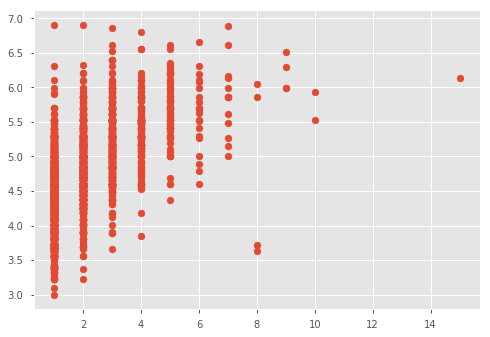

In [70]:
plt.scatter(listing_clean_dummy.beds, np.log(listing_clean_dummy.price))

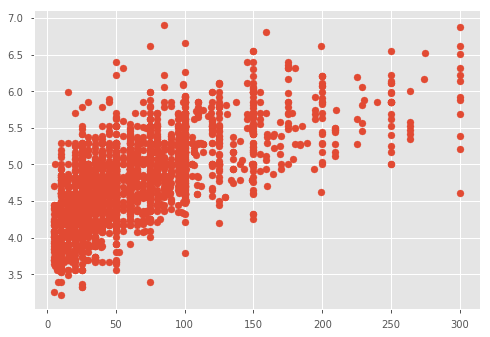

In [71]:
plt.scatter(listing_clean_dummy.cleaning_fee, np.log(listing_clean_dummy.price))

* Number of bedrooms, beds and cleaning fee are positively correlated to price.

Text(0.5, 1.0, 'entire apt vs. other room type price')

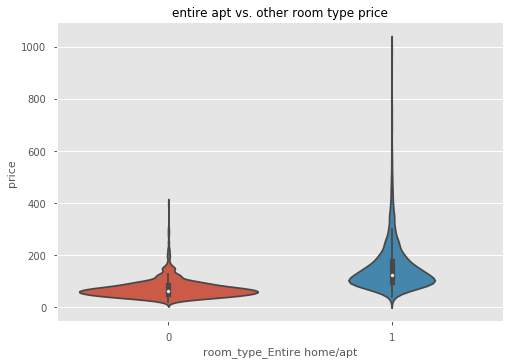

In [72]:
sns.violinplot(x="room_type_Entire home/apt", y="price", data=listing_clean_dummy)
plt.title('entire apt vs. other room type price')

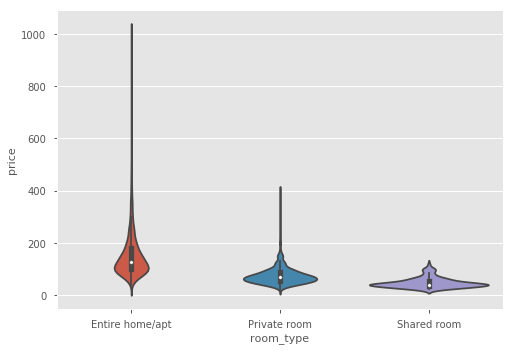

In [73]:
sns.violinplot(x="room_type", y = "price", data = seattle_listing)

* The average price for entire apt doubles that of other room types, and the listings of entire apt have a long tail of very high prices

### 4. XGboost 

In [74]:
import xgboost as xgb
model_xgb = xgb.XGBRegressor(n_estimators=500, colsample_bytree=0.4, 
                             learning_rate=0.01, max_depth=12, 
                             reg_alpha=0.05, 
                             subsample=0.5, seed=42, 
                             random_state =12)
pipeline5 = Pipeline(steps = [
    ('imputer',SimpleImputer(strategy = 'median')),
    ('model', model_xgb)
    ]
)
pipeline5.fit(x_train, y_train)

Pipeline(memory=None,
     steps=[('imputer', SimpleImputer(copy=True, fill_value=None, missing_values=nan,
       strategy='median', verbose=0)), ('model', XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.4, gamma=0, learning_rate=0.01, max_delta_step=0,
       max_depth=12, min_c...     reg_alpha=0.05, reg_lambda=1, scale_pos_weight=1, seed=42,
       silent=True, subsample=0.5))])

In [75]:
print('r2 for training set using random forest is {}'.format(pipeline5.score(x_train, (y_train))))
#best_model = cv.best_estimator_
y_pred_rf = pipeline5.predict(x_test)
#print('best parameters: {}'.format(cv.best_params_))
print('r2 for test set using random forest is {}'.format(pipeline5.score(x_test, (y_test))))

r2 for training set using random forest is 0.9250848350730267
r2 for test set using random forest is 0.6163294893709845


The model is overfitting the training data, did not capture the general pattern.

## Final Thoughts
After several attempts trying different models, the R-squared score in the test set is still not above 0.8. I think it can be caused by a couple of reasons, the biggest one being the data sample is too small(only about 3000). It is hard to draw a generalized pattern with this small sample size and that also leads to overfitting in the training set for random forest.
One way to fix this is to get more Airbnb listing data for other cities to increase the data samples. 